<a href="https://colab.research.google.com/github/GabrielaRomoM/TAM-2025-2/blob/main/Parciales/Parcial1_220925.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error as MSE

# PARCIAL 1 (25%)

**Mapeo a Espacio Polinómico**

Para capturar relaciones no lineales se aplica la transformación polinómica:

$$\Phi_Q(x) = \bigl[x, x^2, x^3, \dots, x^q\bigr]$$

donde $Q \in \mathbb{N}$ es el grado del polinomio. En forma matricial, el problema de regresión se plantea como:

$$\mathbf{y} \approx \Phi \mathbf{w}$$

donde:
- $\Phi \in \mathbb{R}^{n \times Q}$ es la matriz de diseño,
- $\mathbf{w} \in \mathbb{R}^{Q}$ es el vector de coeficientes a estimar.


**Regresión Ridge (Regularización L2)**

La regresión lineal busca resolver:

$$\min_{\mathbf{w}} ||\mathbf{y} - \Phi \mathbf{w}||_2^2$$

En presencia de ruidO, esto puede producir soluciones inestables. La regularización L2 agrega un término penalizante:

$$\min_{\mathbf{w}} J(\mathbf{w}) = ||\mathbf{y} - \Phi \mathbf{w}||_2^2 + \lambda ||\mathbf{w}||_2^2$$

cuya solución analítica es:

$$\hat{\mathbf{w}} = \left( \Phi^\top \Phi + \lambda I \right)^{-1} \Phi^\top \mathbf{y}$$

donde:
- $\lambda \ge 0$ controla la magnitud de los coeficientes,
- $I$ es la matriz identidad.

Esta técnica reduce la varianza del modelo y mejora su capacidad de generalización.

**Cross Validation y Partición de Datos**

Se utiliza validación cruzada para estimar el error de generalización. Dado un conjunto $D = \{(x_i, y_i)\}_{i=1}^n$, se particiona en:

$$D = D_{\text{train}} \cup D_{\text{test}}, \quad
D_{\text{train}} \cap D_{\text{test}} = \emptyset$$

El modelo se entrena en $D_{\text{train}}$ y se evalúa en $D_{\text{test}}$.  Repitiendo este procedimiento varias veces con diferentes particiones, se obtiene una mejor estimación estadística del error esperado:

$$\mathbb{E}[\text{Error}_{\text{test}}]$$

En este caso, se utilizo una partición del 70% para $D_{\text{train}}$ y el 30% para $D_{\text{test}}$.

**Selección de Modelo**

El grado polinomial $Q$ se selecciona resolviendo:

$$Q^* = \arg\min_{q} \ \text{MSE}(Q)$$

Este procedimiento se conoce como búsqueda de hiperparámetros, y permite equilibrar el compromiso entre:

- **Sesgo (Bias):** error introducido por un modelo demasiado simple.
- **Varianza:** sensibilidad a las fluctuaciones de los datos de entrenamiento.

La curva de error en función del grado $Q$ permite identificar:

- **Subajuste (underfitting):** $Q$ pequeño → sesgo alto, error elevado.
- **Sobreajuste (overfitting):** $Q$ grande → varianza alta, error en test elevado.
- **Punto óptimo:** $Q^*$ → minimiza el error de generalización.

## Función Sinc con Ruido Gaussiano

**Función `sinc` y Ruido Gaussiano**

La función definida como:

$$y = \frac{\sin(2\pi 60t)}{2\pi 60t}$$


Se utiliza para generar una señal base suave. Posteriormente, se le añade ruido gaussiano, el cual sigue una distribución normal:

$$\eta \sim \mathcal{N}(0, \sigma^2)$$

donde $\sigma$ es la desviación estándar. El ruido permite simular datos más realistas, introduciendo incertidumbre en las observaciones.

Así, las observaciones se modelan como:

$$y = f(x_i) + \eta_i$$

lo que constituye un **modelo estadístico de regresión**.

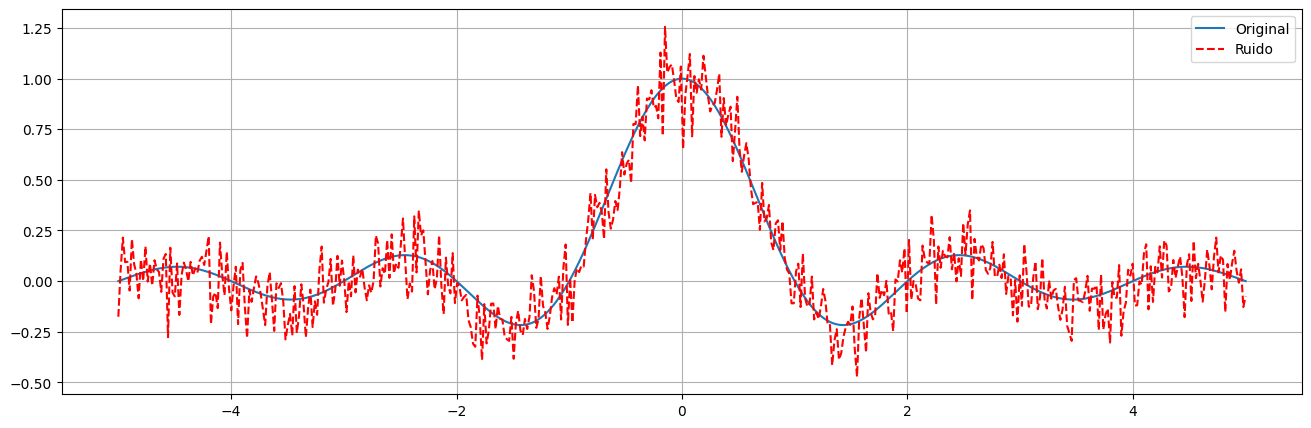

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def sinc_generator(A=1.0, noise_std=0.1, N=500, t_max=5):
    # Crear vector de tiempo
    t = np.linspace(-t_max, t_max, N)

    # Generar señal sinc (np.sinc usa sinc(x) = sin(pi*x)/(pi*x))
    y_clean = A * np.sinc(t)

    # Agregar ruido gaussiano
    ruido = np.random.normal(0, noise_std, size=N)
    y = y_clean + ruido

    return t, y_clean, y

# Ejemplo de uso:
t, y_original, y_ruido = sinc_generator()
plt.figure(figsize=(16,5))
plt.plot(t, y_original, label='Original')
plt.plot(t, y_ruido, 'r--', label='Ruido')
plt.legend()
plt.grid()
plt.show()

In [3]:
#Reshaping
y_reshape = y_ruido.reshape(-1,1)
t_reshape = t.reshape(-1,1)

Q = np.arange(1,50)

#particionar datos
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.3)
for i, (train_i, test_i) in enumerate(rs.split(y_reshape)):
   print(i)

#regresor
lambdaR = 1e-30#hiperparámetro de regularización
reg_mc = Ridge(alpha=lambdaR)
train_i = np.sort(train_i)
test_i = np.sort(test_i)

señales = [None] * len(Q) # Initialize the list with None values
error_noise = [None] * len(Q)
for q in Q:
  phiQ = PolynomialFeatures(degree=q, include_bias=False)
  Phi = phiQ.fit_transform(y_reshape)

  reg_mc.fit(Phi[train_i],t[train_i])
  t_mc = reg_mc.predict(Phi[test_i])
  señales[q-1] = t_mc
  error_noise[q-1] = MSE(t[test_i], t_mc)

0


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.36538e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Grado polinomio óptimo: 1
Error: 8.576940412589446


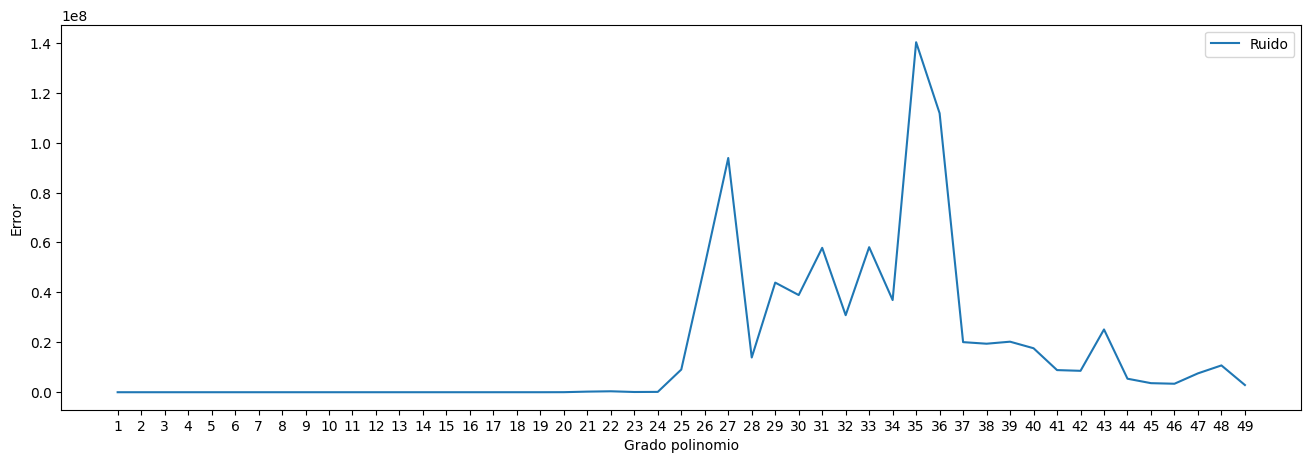

In [4]:
print(f"Grado polinomio óptimo: {np.argmin(error_noise)+1}")
print(f"Error: {error_noise[np.argmin(error_noise)]}")
plt.figure(figsize=(16,5))
plt.plot(Q, error_noise, label='Ruido')
plt.legend()
plt.xticks(Q)
plt.xlabel('Grado polinomio')
plt.ylabel('Error')
plt.show()

In [5]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animar_aproximaciones(t, y_original, y_predichas, grados, test_indices):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_title("Aproximación polinómica a la señal sinc")
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("Amplitud")
    ax.grid()

    # Señal original en negro
    ax.plot(t, y_original, 'k', label="Original")

    # Línea de la predicción que se actualizará
    linea_pred, = ax.plot([], [], 'r', label="Predicción")
    texto_grado = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12, va='top')
    ax.legend()

    def init():
        linea_pred.set_data([], [])
        texto_grado.set_text('')
        return linea_pred, texto_grado

    def update(frame):
        # Use the test_indices to plot the predicted signal at the correct time points
        linea_pred.set_data(t[test_indices], y_predichas[frame])
        texto_grado.set_text(f"Grado del polinomio: {grados[frame]}")
        return linea_pred, texto_grado

    ani = FuncAnimation(fig, update, frames=len(y_predichas), init_func=init, blit=True, interval=500, repeat=True)

    plt.close(fig)  # 👈 Importante para que no muestre una figura estática
    return HTML(ani.to_jshtml())  # 👈 Renderiza la animación como HTML

# Mostrar animación en Colab
animar_aproximaciones(t.flatten(), y_ruido.flatten(), señales, Q, test_i)

## Dataset Housing

In [6]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from ipywidgets import interact

# 1. Dataset
housing = fetch_california_housing(as_frame=True)
X_full = housing.data
y = housing.target.values
features = list(X_full.columns)

# 2. Configuración
lambdaR = 1e-2   # regularización

# 3. Función de graficado
def plot_poly_reg(nombre_feature, grado):
    X = X_full[[nombre_feature]].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=0
    )

    # Transformación polinómica
    phi = PolynomialFeatures(degree=grado, include_bias=False)
    X_train_poly = phi.fit_transform(X_train)
    X_test_poly  = phi.transform(X_test)

    # Modelo
    reg = Ridge(alpha=lambdaR)
    reg.fit(X_train_poly, y_train)

    # Predicciones
    X_plot = np.linspace(X.min(), X.max(), 300).reshape(-1,1)
    y_plot = reg.predict(phi.transform(X_plot))
    y_test_pred = reg.predict(X_test_poly)
    mse = MSE(y_test, y_test_pred)

    # --- Gráfico ---
    plt.figure(figsize=(6,4))
    plt.scatter(X_train, y_train, color="gray", alpha=0.4, s=10, label="Datos train")
    plt.plot(X_plot, y_plot, "r", lw=2, label=f"Polinomio grado {grado}")
    plt.title(f"Feature: {nombre_feature}\nMSE Test = {mse:.3f}")
    plt.xlabel(nombre_feature)
    plt.ylabel("Valor medio vivienda")
    plt.legend()
    plt.grid(True)
    plt.show()

# 4. Interfaz interactiva
interact(
    plot_poly_reg,
    nombre_feature=widgets.Dropdown(options=features, value="MedInc", description="Feature:"),
    grado=widgets.IntSlider(min=1, max=15, step=1, value=2, description="Grado:")
);

interactive(children=(Dropdown(description='Feature:', options=('MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',…